# Аналитика по данным сдвижений реперов геодинамического полигона

## Введение

Исходные данные представляют собой таблицу excel с координатами всех реперов за каждый цикл измерений. Под циклом можно подразумевать один выезд для измерений всех точек (далее точки будут называться профессиональным термином - репер). Существует понятие контрольного цикла, это первое измерение координат, или тот цикл в которым будут сравниваться все остальные.  
В проекте будет 2 раздела: нивелирование и спутниковые измерения.
1. Нивелирование это высокоточное измерение (точность 2мм.) но только одной координаты Z. По сути мы увидим проседает ли поверхность либо происходит поднятие.
2. Спутниковые измерения происходят по всем осям (X,Y,Z) точность таких измерений хуже( порядка 3-5см) но при этом они менее трудозатратны.





## Анализ данных измерений нивелирования профильной линии

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [76]:
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import CARTODBPOSITRON, get_provider, ESRI_IMAGERY, OSM, STAMEN_TERRAIN
from bokeh.models import ColumnDataSource, LabelSet, ColorBar, Toggle, GraphRenderer, Ellipse, StaticLayoutProvider
from bokeh.io import output_notebook, export_png
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead
from bokeh.layouts import layout
from bokeh.palettes import Turbo256, Blues, Spectral6, Plasma256, Blues256, BuGn9, BrBG9, YlGnBu9
from bokeh.transform import linear_cmap
output_notebook()

In [4]:
plt.style.use('seaborn')

In [5]:
#uploaded = files.upload()

### Загрузка основного датасета

Датасет я собрал на одном листе файла excel, но предобработку не проводил

In [6]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Vega_niv/Сдвижения всем циклам (нив).xlsx', header = 0, sheet_name=2)

In [7]:
df.head()

,репер,расстояние,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,Rp 8,0.0,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.392,-14.391,-14.391,-14.391,-14.391
1,NaN,0.5,-13.807,-13.807,-13.808,-13.807,-13.807,-13.807,-13.808,-13.807,-13.808,-13.808,-13.808,-13.809,-13.810,-13.810,-13.809,-13.810,-13.809,-13.810,-13.811,-13.812,-13.810,-13.811,-13.811,-13.812,-13.810,-13.811,-13.812
2,NaN,1.0,-18.280,-18.281,-18.282,-18.282,-18.282,-18.281,-18.281,-18.280,-18.280,-18.281,-18.280,-18.281,-18.281,-18.283,-18.280,-18.283,-18.293,-18.293,-18.281,-18.281,-18.280,-18.280,-18.282,-18.282,-18.283,-18.284,-18.285
3,NaN,1.5,-17.232,-17.233,-17.235,-17.235,-17.235,-17.233,-17.233,-17.233,-17.233,-17.234,-17.233,-17.234,-17.235,-17.237,-17.234,-17.237,-17.244,-17.245,-17.236,-17.237,-17.235,17.236,-17.235,-17.235,-17.236,-17.236,-17.235
4,NaN,2.0,-16.084,-16.086,-16.088,-16.087,-16.087,-16.086,-16.087,-16.087,16.088,-16.087,-16.086,-16.088,-16.089,16.091,16.087,-16.091,-16.095,-16.095,-16.089,-16.089,-16.088,-16.088,-16.090,-16.087,-16.091,-16.092,-16.091


Таблица содержит столбец с названием репера, расстоянием от начального до текущего репера в км и измеренные координаты его в каждый цикл измерений вплоть до 28 (проводился весной 2021года).  
Как видно в названии реперов будут есть потому что тут даны только контрольные реперы, а промежуточных нет, файл со всеми значениями подгрузим ниже

### Загрузка файла с номерами реперов

In [8]:
df_1= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vega_niv/reper.txt',header=None)

### Предобработка данных

Посмотрим на наш основной датасет

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   репер        7 non-null      object 
 1   расстояние   48 non-null     float64
 2   2            48 non-null     float64
 3   3            48 non-null     float64
 4   4            48 non-null     float64
 5   5            48 non-null     float64
 6   6            48 non-null     float64
 7   7            48 non-null     float64
 8   8            48 non-null     float64
 9   9            48 non-null     float64
 10  10           48 non-null     float64
 11  11           48 non-null     float64
 12  12           48 non-null     float64
 13  13           48 non-null     float64
 14  14           48 non-null     float64
 15  15           48 non-null     float64
 16  16           48 non-null     float64
 17  17           48 non-null     float64
 18  18           48 non-null     float64
 19  19        

Все столбцы заполнены числами типа float, так нам и нужно, ведь координаты даны с точностью до 3-его знака после запятой. Координата дана с метрах, значит последний знак будет соответствовать миллиметрам. Пропущены значения только в названии реперов, но мы уже об этом знаем.

Посмотрим описательную статистику

In [10]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
расстояние,48.0,10.85,6.16,0.00,5.80,11.25,15.60,21.40
2,48.0,-14.77,1.76,-18.28,-16.11,-14.90,-13.80,-10.94
3,48.0,-14.77,1.76,-18.28,-16.12,-14.90,-13.80,-10.94
4,48.0,-14.78,1.76,-18.28,-16.12,-14.91,-13.80,-10.94
5,48.0,-14.77,1.76,-18.28,-16.12,-14.90,-13.80,-10.94
6,48.0,-14.77,1.76,-18.28,-16.12,-14.90,-13.80,-10.94
7,48.0,-14.77,1.76,-18.28,-16.12,-14.90,-13.80,-10.94
8,48.0,-14.78,1.76,-18.28,-16.12,-14.90,-13.80,-10.94
9,48.0,-14.78,1.76,-18.28,-16.12,-14.91,-13.80,-10.94
10,48.0,-14.11,4.78,-18.28,-15.85,-14.73,-13.78,16.09


Интересно, стандартное отклонение сильно отличается по столбцам, в основном оно 1.76, но есть значения значительно больше (и 4, и 6, и даже 8). Так же для этих значений std максимальное значение больше нуля, что явно ошибка.  
Потому что система координат высот Балтийская, значит 0 это уровень Балтийского моря, но мне известно что территория на которой проводились измерения ниже этого уровня и должна иметь отрицательные координаты.

Разберемся в каких циклах у нас появились ошибки. Выведем все столбцы где наш максимум выше нуля

In [11]:
df.describe().T[df.describe().T['max'] > 0]

,count,mean,std,min,25%,50%,75%,max
расстояние,48.0,10.847917,6.163067,0.000,5.80000,11.2500,15.60000,21.400
10,48.0,-14.106979,4.784058,-18.280,-15.85225,-14.7315,-13.77600,16.088
11,48.0,-13.636979,6.014396,-18.281,-16.11850,-14.9065,-13.77450,13.885
14,48.0,-13.518667,6.291243,-18.281,-15.82350,-14.7375,-13.78150,16.625
15,48.0,-14.112687,4.785428,-18.283,-15.85900,-14.7415,-13.78500,16.091
16,48.0,-14.112479,4.784425,-18.280,-15.86025,-14.7420,-13.78525,16.087
23,48.0,-12.213771,8.608652,-18.280,-15.73525,-14.5220,-13.62150,17.236


И так 10, 11, 14, 15, 16 и 23 циклы. Не так уж много.
Возьмем срез по этим циклам

In [12]:
df.loc[:, [10, 11, 14, 15, 16, 23]].head(10)

,10,11,14,15,16,23
0,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391
1,-13.808,-13.808,-13.810,-13.810,-13.809,-13.811
2,-18.280,-18.281,-18.281,-18.283,-18.280,-18.280
3,-17.233,-17.234,-17.235,-17.237,-17.234,17.236
4,16.088,-16.087,-16.089,16.091,16.087,-16.088
5,-17.274,-17.272,-17.274,-17.276,-17.273,-17.274
6,-16.498,-16.495,-16.498,-16.501,-16.497,-16.498
7,-17.742,-17.738,-17.741,-17.744,-17.740,-17.742
8,-15.256,-15.251,-15.255,-15.259,-15.255,-15.258
9,-15.552,-15.547,-15.552,-15.556,-15.551,-15.553


Сложно определить где ошибка, глаз "замыливается". Добавим сравнение.  
Результат сравнения выведет всю таблицу и где значение будет удовлетворять условию оно останется, а где не будет мы увидим NaN. Сразу удалю строки где все значения будут равны NaN.

In [13]:
df.loc[:, [10, 11, 14, 15, 16, 23]][df.loc[:, [10, 11, 14, 15, 16, 23]] > 0].dropna(how='all')

,10,11,14,15,16,23
3,NaN,NaN,NaN,NaN,NaN,17.236
4,16.088,NaN,NaN,16.091,16.087,NaN
11,NaN,NaN,NaN,NaN,NaN,14.334
13,NaN,NaN,NaN,NaN,NaN,13.735
15,NaN,NaN,16.625,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,16.486
20,NaN,13.460,NaN,NaN,NaN,NaN
24,NaN,13.885,NaN,NaN,NaN,NaN
25,NaN,NaN,13.658,NaN,NaN,NaN


А вот и ответ на вопрос, это наши координаты, только в них отсутствует знак минуса. Это по строке с 4 индексом хорошо заметно, координаты примерно одни и те же, отличаются только последними знаками.

In [14]:
# Возьмем список этих строк
rows_for_change = df.loc[:, [10, 11, 14, 15, 16, 23]][df.loc[:, [10, 11, 14, 15, 16, 23]] > 0].dropna(how='all').index
# Возьмем список колонок
cols_for_change = df.loc[:, [10, 11, 14, 15, 16, 23]][df.loc[:, [10, 11, 14, 15, 16, 23]] > 0].dropna(how='all').columns

In [15]:
# Проверка работы
df.loc[rows_for_change, cols_for_change]

,10,11,14,15,16,23
3,-17.233,-17.234,-17.235,-17.237,-17.234,17.236
4,16.088,-16.087,-16.089,16.091,16.087,-16.088
11,-14.328,-14.322,-14.329,-14.333,-14.329,14.334
13,-13.731,-13.725,-13.732,-13.737,-13.732,13.735
15,-16.620,-16.617,16.625,-16.629,-16.627,-16.635
16,-16.473,-16.470,-16.479,-16.482,-16.480,16.486
20,-13.460,13.460,-13.467,-13.471,-13.472,-13.482
24,-13.886,13.885,-13.893,-13.897,-13.899,-13.911
25,-13.651,-13.651,13.658,-13.661,-13.664,-13.675


Значений не много, можно пройтись питоновским циклом по ним и заменить на отрицательное ниже функция за это отвечающая.

In [16]:
def change_value_df(df):
    new_df = df.copy()
    for column in new_df.columns:
        for index in new_df[column].index:
            if new_df[column][index] > 0:
                new_df[column][index] = new_df[column][index] * -1
    return new_df

Заменяем значения в нашем рабочем DataFrame

In [17]:
df.loc[[3,4,11,13,15,16,20,24,25], [10, 11, 14, 15, 16, 23]] = change_value_df(df.loc[rows_for_change, cols_for_change])

Если все сработало наш срез с NaN значениями не даст результатов. Скопируем код сюда

In [18]:
df.loc[:, [10, 11, 14, 15, 16, 23]][df.loc[:, [10, 11, 14, 15, 16, 23]] > 0].dropna(how='all')

,10,11,14,15,16,23


Сделаем новый столбец со всеми именами реперов из нашего загруженного файла

In [19]:
df['reper'] = df_1

In [20]:
df.head(3)

,репер,расстояние,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,reper
0,Rp 8,0.0,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.392,-14.391,-14.391,-14.391,-14.391,8
1,NaN,0.5,-13.807,-13.807,-13.808,-13.807,-13.807,-13.807,-13.808,-13.807,-13.808,-13.808,-13.808,-13.809,-13.810,-13.810,-13.809,-13.810,-13.809,-13.810,-13.811,-13.812,-13.810,-13.811,-13.811,-13.812,-13.810,-13.811,-13.812,8-7T/1
2,NaN,1.0,-18.280,-18.281,-18.282,-18.282,-18.282,-18.281,-18.281,-18.280,-18.280,-18.281,-18.280,-18.281,-18.281,-18.283,-18.280,-18.283,-18.293,-18.293,-18.281,-18.281,-18.280,-18.280,-18.282,-18.282,-18.283,-18.284,-18.285,8-7T/2


Для удобства и наглядности изменим названия колонок с цифры на имя цикла и его названия

In [21]:
df.columns =   ['репер', 'расстояние', *[('Цикл_' + str(i)) for i in range(2,29)], 'reper']

In [22]:
df.head(2)

,репер,расстояние,Цикл_2,Цикл_3,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,reper
0,Rp 8,0.0,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.391,-14.392,-14.391,-14.391,-14.391,-14.391,8
1,NaN,0.5,-13.807,-13.807,-13.808,-13.807,-13.807,-13.807,-13.808,-13.807,-13.808,-13.808,-13.808,-13.809,-13.810,-13.810,-13.809,-13.810,-13.809,-13.810,-13.811,-13.812,-13.810,-13.811,-13.811,-13.812,-13.810,-13.811,-13.812,8-7T/1


### Создание таблицы для построения графиков

Теперь на нужно получить новый датафрейм в котором у нас будет указано в каждом цикле начиная с 3-его(!). Разницу координат цикла со 2-ым циклом, который является контрольным.  
Логика такая: допустим у нас кооридана точки в начале была 2, а стала -5. Значит -5 - 2 = -7, точка опустилась на 7 метров.

In [23]:
df_new = df[['reper', 'расстояние']]

Проверяю точно ли я посчитал индекс последнего столбца.

In [24]:
df.columns[29]

'reper'

In [25]:
for column in df.columns[3:29]:
    df_new[column] = df[column] - df['Цикл_2']

Посмотрим на наш новый датафрейм, напомню сдеть колонка с циклом, означает разницу координат цикла с контрольным. То есть в ```new_df['Цикл_7'] = df['Цикл_7'] - df['Цикл_2']``` 

In [26]:
df_new.head()

,reper,расстояние,Цикл_3,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28
0,8,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.001,0.000,0.000,0.000,0.000
1,8-7T/1,0.5,0.000,-0.001,0.000,0.000,0.000,-0.001,0.000,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.002,-0.003,-0.002,-0.003,-0.004,-0.005,-0.003,-0.004,-0.004,-0.005,-0.003,-0.004,-0.005
2,8-7T/2,1.0,-0.001,-0.002,-0.002,-0.002,-0.001,-0.001,0.000,0.000,-0.001,0.000,-0.001,-0.001,-0.003,0.000,-0.003,-0.013,-0.013,-0.001,-0.001,0.000,0.000,-0.002,-0.002,-0.003,-0.004,-0.005
3,8-7T/3,1.5,-0.001,-0.003,-0.003,-0.003,-0.001,-0.001,-0.001,-0.001,-0.002,-0.001,-0.002,-0.003,-0.005,-0.002,-0.005,-0.012,-0.013,-0.004,-0.005,-0.003,-0.004,-0.003,-0.003,-0.004,-0.004,-0.003
4,8-7T/4,2.0,-0.002,-0.004,-0.003,-0.003,-0.002,-0.003,-0.003,-0.004,-0.003,-0.002,-0.004,-0.005,-0.007,-0.003,-0.007,-0.011,-0.011,-0.005,-0.005,-0.004,-0.004,-0.006,-0.003,-0.007,-0.008,-0.007


### Визуализация на разрезе


Построения по данным из нашего датафрейма это по сути разрез по нашей линии нивелирования.  
То есть, на данном графике мы смотрим как бы вдоль нее.

Посмотрю в первом приближении все ли впорядке с данными, перед построением интерактивного графика

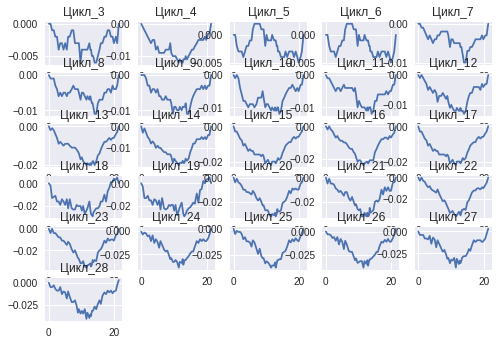

In [27]:
fig=plt.figure()
i = 1
for column in df_new.drop(['reper', 'расстояние'], axis = 1).columns:
    plt.subplot(6,5,i)
    plt.plot(df_new['расстояние'], df_new[column])
    plt.title(column)
    i +=1

Никаких казусов не произошло, все графики строятся.
Теперь сделаю с seaborn общий график

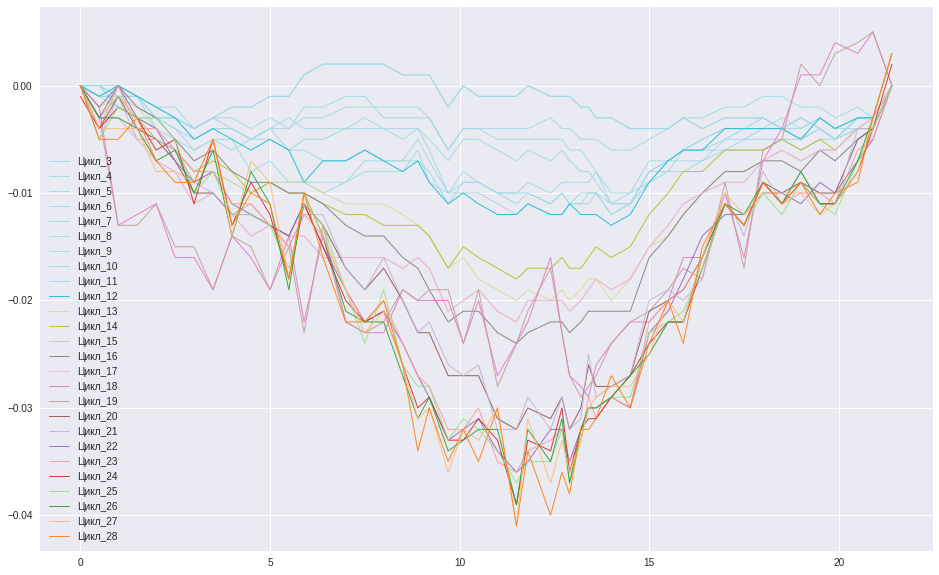

In [28]:
plt.figure(figsize=(16,10))
palette = plt.get_cmap('tab20')
num=28
for column in df_new.drop(['reper', 'расстояние'],axis=1):
    num -= 1
    plt.plot(df_new['расстояние'], df_new[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()

Видно что на расстоянии 10-15 км от начального репера происходят самые большие оседания, но он все равно неинформативен. 
Теперь построим интерактивный график в библиотеке plotly.

In [29]:
fig = go.Figure()

for column in df_new.drop(['reper', 'расстояние'],axis=1):
    fig.add_trace(go.Scatter(x=df_new['расстояние'], y=df_new[column], mode = 'lines+markers', name=column))
fig.update_layout(
            legend_orientation="h",
            margin=dict(l=0, r=60, t=30, b=0),
            title="График сдвижения по данным нивелирования",
            xaxis_title="Расстояние от начального репера, км.",
            yaxis_title="Оседания, мм",
            )
fig.update_traces(hoverinfo="all")
fig.show()

Уже лучше, теперь я могу навести на любую точку и увидеть величину сдвижения и узнать номер цикла наблюдений. Только сделаю нашу ось x не с расстояниями, а с номерами реперов на местности

In [30]:
fig = go.Figure()

for column in df_new.drop(['reper', 'расстояние'],axis=1):
    fig.add_trace(go.Scatter(x=df_new['reper'], y=df_new[column], mode = 'lines+markers', name=column))
fig.update_layout(
            legend_orientation="v",
            margin=dict(l=0, r=60, t=30, b=20),
            title="График сдвижения по данным нивелирования",
            title_x = 0.5,
            title_y = 1.0,
            title_font_size=20,
            xaxis_title="Название репера",
            yaxis_title="Оседания, мм",
            )
fig.update_traces(hoverinfo="all")
fig.update_xaxes(tickangle=45,
                            title_font = {"size": 18},
                            ticks="outside", 
                            tickwidth=2, 
                            tickcolor='gray', 
                            ticklen=10)
fig.update_yaxes(ticks="outside",
                            title_font = {"size": 18}, 
                            tickwidth=2, 
                            tickcolor='gray', 
                            ticklen=10)
fig.show()

#### Промежуточный вывод:

Видно что самые большие оседания происходят между рпевером 12T и 4T. Со временем в этом месте происходило их плавное учеличение. Величины не критические порядка 3-4см.

### Визуализация на карте

Данная визуализация уже поможет техническим службам принимать решения о защите объектов от воздействия этих сдвижений, но было бы неплохо нанести все на карту и посмотреть где же сами репера находятся на местности. Для этого я выбрал и изучил библиотеку bokeh, она так-же построена на j-s и имеет необходимые функции.

In [31]:
#uploaded = files.upload()

Для того что бы нанести на карту нам нужны координаты наших реперов. Да еще и в нужной системе координат. Так как библиотека bokeh использует систему web-mercator, все координаты нужно приводить к ней. Очень важно понимать что в гегорафических построениях ось X направлена на север, а Y на восток. Это часто путают так как обычной декартовой все наоборот 

Файл с координатами я подготовил, и загружу его. Напомню что я из целесообразности внес некие коэффициенты в координаты, так как точные я не имею права публиковать.

In [32]:
data_coord_niv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vega_niv/niv_reper_web_mercator.txt', sep="\t", header=0)
data_coord_niv.columns = ["reper", "x", "y"]

In [33]:
data_coord_niv.head()

,reper,x,y
0,12T-7T/1,5373215.936,5903645.708
1,12T-7T/2,5372662.678,5903455.575
2,12T-7T/3,5372230.758,5903301.196
3,12T-7T/4,5371691.972,5903120.820
4,12T-7T/5,5371240.015,5902955.072


In [34]:
data_coord_niv['reper'].unique()

array(['12T-7T/1', '12T-7T/2', '12T-7T/3', '12T-7T/4', '12T-7T/5',
       '12T-8T/1', '12T-8T/2', '12T-8T/3', '12T-8T/4', '12T-8T/5',
       '12T-8T/6', '8T-4T/1', '8T-4T/2', '8T-4T/3', '8T-4T/4', '4T-6/1',
       '4T-6/2', '4T-6/3', '4T-6/4', '4T-6/5', '4T-6/6', '4T-6/7',
       '4T-6/8', '4T-6/9', '4T-6/10', '4T-6/11', '4T-6/12', '4T-6/13',
       '4T-6/14', '4T-6/15', '8-7T/1', '8-7T/2', '8-7T/3', '8-7T/4',
       '8-7T/5', '8-7T/6', '8-7T/7', '8-7T/8', '8-7T/9', '8-7T/10',
       '8-7T/11', '8-7T/12', '8', '7T', '12T', '8T', '4T', '6'],
      dtype=object)

Файл простой название репера и его географические координаты x и y.
Но есть одно но в этом файле репера 6-4T/1 - 6-4T/15 здесь названы наоборот, 4T-6/1 - 4T-6/15. Это нужно исправить.

In [35]:
for i in range(len(data_coord_niv)):
    if '4T-6' in data_coord_niv['reper'][i]:
        # Разделяем по знаку что бы получить список из одного репера и другого с цифрой через '/'
        first_split = data_coord_niv['reper'][i].split('-')
        # Еще раз делим что бы отделить номер 
        second_split = first_split[1].split('/')
        # Собираем все вместе
        total_str = second_split[0] + '-' + first_split[0] + '/' + second_split[1]
        # Заменяем значение
        data_coord_niv['reper'][i] = total_str

In [36]:
data_coord_niv['reper'].unique()

array(['12T-7T/1', '12T-7T/2', '12T-7T/3', '12T-7T/4', '12T-7T/5',
       '12T-8T/1', '12T-8T/2', '12T-8T/3', '12T-8T/4', '12T-8T/5',
       '12T-8T/6', '8T-4T/1', '8T-4T/2', '8T-4T/3', '8T-4T/4', '6-4T/1',
       '6-4T/2', '6-4T/3', '6-4T/4', '6-4T/5', '6-4T/6', '6-4T/7',
       '6-4T/8', '6-4T/9', '6-4T/10', '6-4T/11', '6-4T/12', '6-4T/13',
       '6-4T/14', '6-4T/15', '8-7T/1', '8-7T/2', '8-7T/3', '8-7T/4',
       '8-7T/5', '8-7T/6', '8-7T/7', '8-7T/8', '8-7T/9', '8-7T/10',
       '8-7T/11', '8-7T/12', '8', '7T', '12T', '8T', '4T', '6'],
      dtype=object)

Все сработало

In [37]:
data_coord_niv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   reper   48 non-null     object 
 1   x       48 non-null     float64
 2   y       48 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


Еще раз убедились что с данными в файле все впорядке

Взглянем еще раз на наш датафрейм, и будем в него добавлять координаты X и Y

In [38]:
df_new.head(2)

,reper,расстояние,Цикл_3,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28
0,8,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.001,0.000,0.000,0.000,0.000
1,8-7T/1,0.5,0.0,-0.001,0.0,0.0,0.0,-0.001,0.0,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.002,-0.003,-0.002,-0.003,-0.004,-0.005,-0.003,-0.004,-0.004,-0.005,-0.003,-0.004,-0.005


In [39]:
df_to_concat = df_new.copy()
df_final = df_to_concat.merge(data_coord_niv, how='inner', on='reper')

In [40]:
df_final.head()

,reper,расстояние,Цикл_3,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,x,y
0,8,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.001,0.000,0.000,0.000,0.000,5370206.970,5893783.706
1,8-7T/1,0.5,0.000,-0.001,0.000,0.000,0.000,-0.001,0.000,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.002,-0.003,-0.002,-0.003,-0.004,-0.005,-0.003,-0.004,-0.004,-0.005,-0.003,-0.004,-0.005,5370224.781,5894480.114
2,8-7T/2,1.0,-0.001,-0.002,-0.002,-0.002,-0.001,-0.001,0.000,0.000,-0.001,0.000,-0.001,-0.001,-0.003,0.000,-0.003,-0.013,-0.013,-0.001,-0.001,0.000,0.000,-0.002,-0.002,-0.003,-0.004,-0.005,5370252.611,5895166.836
3,8-7T/3,1.5,-0.001,-0.003,-0.003,-0.003,-0.001,-0.001,-0.001,-0.001,-0.002,-0.001,-0.002,-0.003,-0.005,-0.002,-0.005,-0.012,-0.013,-0.004,-0.005,-0.003,-0.004,-0.003,-0.003,-0.004,-0.004,-0.003,5370277.101,5895868.224
4,8-7T/4,2.0,-0.002,-0.004,-0.003,-0.003,-0.002,-0.003,-0.003,-0.004,-0.003,-0.002,-0.004,-0.005,-0.007,-0.003,-0.007,-0.011,-0.011,-0.005,-0.005,-0.004,-0.004,-0.006,-0.003,-0.007,-0.008,-0.007,5370302.705,5896574.540


Координаты добавлены, теперь начнем строить карты.

In [41]:
output_notebook()

Что бы начать строить интерактивную карту нужно импортировать и подгрузить tile(на русский нет подходящего перевода, но это может быть и гугл карты и OpenSteetMap, в дальнейшем будем пробовать разные.

In [42]:
tile_provider_esri = get_provider(ESRI_IMAGERY)

# указывает тип координат в нашей фигуре и ее форму
p = figure(
                x_axis_type="mercator",
                y_axis_type="mercator",
                width=700,
                height=700
           )
# добавляем карту
p.add_tile(tile_provider_esri)
# отрисовка реперов
p.circle_x(x=df_final['x'],
             y=df_final['y'],          
             size=12,
             color='black',
             fill_color="white", 
             fill_alpha=1)
# отрисовка профильной линни
p.line(df_final['x'], df_final['y'], line_width=2)
show(p)

Неплохо, но мало информативности, хочу что бы при наведении на каждую точку показывалось ее сдвижение причем в миллиметрах.  Указывать будем только последний (самый актуальный) цикл

In [43]:
# Добавим соответствующий столбец
df_final['cycle_28'] = round(df_final['Цикл_28']*1000)
df_final.head()

,reper,расстояние,Цикл_3,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,x,y,cycle_28
0,8,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.001,0.000,0.000,0.000,0.000,5370206.970,5893783.706,0.0
1,8-7T/1,0.5,0.000,-0.001,0.000,0.000,0.000,-0.001,0.000,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.002,-0.003,-0.002,-0.003,-0.004,-0.005,-0.003,-0.004,-0.004,-0.005,-0.003,-0.004,-0.005,5370224.781,5894480.114,-5.0
2,8-7T/2,1.0,-0.001,-0.002,-0.002,-0.002,-0.001,-0.001,0.000,0.000,-0.001,0.000,-0.001,-0.001,-0.003,0.000,-0.003,-0.013,-0.013,-0.001,-0.001,0.000,0.000,-0.002,-0.002,-0.003,-0.004,-0.005,5370252.611,5895166.836,-5.0
3,8-7T/3,1.5,-0.001,-0.003,-0.003,-0.003,-0.001,-0.001,-0.001,-0.001,-0.002,-0.001,-0.002,-0.003,-0.005,-0.002,-0.005,-0.012,-0.013,-0.004,-0.005,-0.003,-0.004,-0.003,-0.003,-0.004,-0.004,-0.003,5370277.101,5895868.224,-3.0
4,8-7T/4,2.0,-0.002,-0.004,-0.003,-0.003,-0.002,-0.003,-0.003,-0.004,-0.003,-0.002,-0.004,-0.005,-0.007,-0.003,-0.007,-0.011,-0.011,-0.005,-0.005,-0.004,-0.004,-0.006,-0.003,-0.007,-0.008,-0.007,5370302.705,5896574.540,-7.0


In [44]:
# Специальный метод работы с данными в bokeh
source = ColumnDataSource(data=df_final[['reper', 'x', 'y', 'cycle_28']])
# Инструменты при наведении которые хочу видеть
TOOLTIPS = [
    ("Репер", "@reper"),
    ("Оседание, мм.", "@cycle_28"),
]
# Добавим еще один поставщик тайлов
tile_provider_osm = get_provider(OSM)

In [45]:
# указывает тип координат в нашей фигуре и ее форму
p = figure(
                x_axis_type="mercator",
                y_axis_type="mercator",
                width=1200,
                height=800,
                tooltips=TOOLTIPS
           )
# добавляем карту
p.add_tile(tile_provider_esri)
# отрисовка профильной линни
p.line('x', 'y', line_width=2,legend_label="Профильная линия",source=source)
# отрисовка реперов
p.circle_x(x='x',
             y='y',          
             size=10,
             color='black',
             fill_color="white", 
             fill_alpha=1,
             source=source,
             legend_label="Реперы")
# Настроим легенду
p.legend.title = "Условные обозначения"
p.legend.border_line_width = 3
p.legend.border_line_color = "black"
p.legend.border_line_alpha = 0.8
# Отобразим названия реперов
labels = LabelSet(x='x', y='y', text='reper',
              x_offset=10, y_offset=-10, source=source, render_mode='canvas', text_color='black', text_font_size = {'value': '12px'})
p.add_layout(labels)
show(p)

Отлично! Теперь при наведении на каждую точку мы увидем ее сдвижение. Если смущают  накладывающиеся названия, то карту всегда можно увеличить и посмотреть интересующие данные.  
Посмотрите на нижнюю часть карты, слева от нашей профильной линни есть черный квадрат, так как со спутника выглядит емкость с жидкостью а репер 8 проходит рядом с железной дорогой. Для человека принимающего технические решения (например главного инженера компании) было бы удобно раскрасить репера в зависисмости от величины оседания. Этим и займемся.

#### Итоговая карта

Создам новую структуру данных для отображения такого графика

In [46]:
x = df_final['x']
y = df_final['y']
z = df_final['Цикл_28']
text = df_final['reper']
mapper = linear_cmap(field_name='z', palette=YlGnBu9, low=min(z) ,high=max(z))
source_new = ColumnDataSource(dict(x=x,y=y,z=z, reper=text, cycle_28=df_final['cycle_28']))

Отрисовываем карту

In [47]:
# указывает тип координат в нашей фигуре и ее форму
p_1 = figure(
# добавил границы координат что бы сразу была видна часть территории предприятия
                x_range=(5365000, 5375000),
                y_range=(5890000, 5917000),
                x_axis_type="mercator",
                y_axis_type="mercator",
                width=1200,
                height=800,
                tooltips=TOOLTIPS
           )
# добавляем карту openstreetmap
p_1.add_tile(tile_provider_osm)
# отрисовка профильной линни
p_1.line('x', 'y', line_width=2,legend_label="Профильная линия",source=source_new)
# отрисовка реперов
p_1.circle(x='x',
             y='y',          
             size=10,
             line_color='black',
             color=mapper,
             fill_alpha=1,
             source=source_new,
             legend_label="Реперы")
# Настроим легенду
p_1.legend.title = "Условные обозначения"
p_1.legend.location = "top_left"
p_1.legend.border_line_width = 3
p_1.legend.border_line_color = "black"
p_1.legend.border_line_alpha = 0.8
# Отобразим названия реперов
labels = LabelSet(x='x', y='y', text='reper',
              x_offset=10, y_offset=-10, source=source_new, render_mode='canvas', text_color='black', text_font_size = {'value': '12px'})
p_1.add_layout(labels)
# Добавим цветовую шкалу
color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
p_1.add_layout(color_bar, 'right')

show(p_1)

#### Промежуточный вывод

Вот теперь вся информация видна нам и на карте. Как и было с разрезом мы видим темно- синие точки которые имеют самые высокие значения оседаний, их мы можем посмотреть наведя на них курсор. Ну а наши репера ближайшие к емкости имеют малые значения оседаний. Так же можно эту карту сохранить в файл и ее можно открыть на любом компьютере с браузером, это удобней чем тащить отчеты и самому показывать где что находится.

На этом еще не все, у нас осталась сеть реперов по которым мы измеряем все 3 координаты пространственного положения с использованием спутникового оборудования. об этом в следующем разделе

# Спутниковые измерения

Сеть спутниковых наблюдений стостоит из 21 репера (6 опорных и 15 рабочих). Рабочие реперы имеют в названии букву T. Опорные считаются неподвижными. Есть репера которые вошли и нивелирные и спутниковые измерения их всего 5 (7T, 12T, 8T, 4T, 6).  
С ними работа сложнее так как на каждой точке у нас вместо одного измерения уже 3

### Загрузка датасета

In [48]:
df_gnss = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Vega_niv/высотно-плановое положение реперов Вега ПХГ.xlsx',header = 0, sheet_name=4)

И так посмотрим на него

In [49]:
df_gnss.head()

,Цикл,Репер,1T,2T,3T,4T,5T,6T,7T,8T,9T,10T,11T,12T,13T,14T,15T
0,3.0,X,5181673.425,5183730.929,5181976.046,5185771.976,5183070.532,5180983.149,5181991.117,5185034.214,5184368.075,5181428.296,5182765.397,5182679.247,5180966.641,5190811.411,5193148.768
1,NaN,Y,291799.977,294046.521,293664.354,294622.549,292806.435,290459.296,289533.642,293685.301,295454.031,292816.466,294461.963,291807.565,293839.912,277299.631,281942.255
2,NaN,Z,-24.738,-24.277,-24.023,-25.108,-22.565,-24.638,-23.150,-21.502,-25.262,-26.772,-22.844,-23.875,-26.494,-24.982,-25.314
3,4.0,X,5181673.421,5183730.926,5181976.050,5185771.964,5183070.530,5180983.149,5181991.116,5185034.207,5184368.072,5181428.293,5182765.395,5182679.245,5180966.640,5190811.411,5193148.761
4,NaN,Y,291799.974,294046.517,293664.354,294622.537,292806.434,290459.291,289533.638,293685.299,295454.026,292816.464,294461.957,291807.563,293839.915,277299.626,281942.247


In [50]:
df_gnss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Цикл    27 non-null     float64
 1   Репер   81 non-null     object 
 2   1T      81 non-null     float64
 3   2T      81 non-null     float64
 4   3T      81 non-null     float64
 5   4T      81 non-null     float64
 6   5T      81 non-null     float64
 7   6T      81 non-null     float64
 8   7T      81 non-null     float64
 9   8T      81 non-null     float64
 10  9T      81 non-null     float64
 11  10T     81 non-null     float64
 12  11T     81 non-null     float64
 13  12T     81 non-null     float64
 14  13T     81 non-null     float64
 15  14T     81 non-null     float64
 16  15T     81 non-null     float64
dtypes: float64(16), object(1)
memory usage: 10.9+ KB


В этом датасете уже в столбцах наши реперы а строки это координаты в каждом цикле. Каждый цикл содержит 3 координаты X,Y,Z. Мы имеем пропуски в столбце цикла, то есть номер цикла есть но он стоит не напротив всех координат. Плюс неарвильное название колонки 'Репер' это тип координаты.

### Предобработка данных

Проверим какие значения у нас в столбце цикл есть вообще

In [51]:
np.sort(df_gnss['Цикл'].unique())

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., nan])

Так как кординаты расположены по порядку циклов. Можно сделать список из повторябщихся по 3 раза значений номера каждого цикла, сделать из него датафрейм и заполнить им значения уже нашего столбца

In [52]:
list_for_df_fill = sorted([i for i in range(3,30)]*3);

In [53]:
df_for_fill = pd.DataFrame(list_for_df_fill, columns=['Цикл'])
df_for_fill.head(6)

,Цикл
0,3
1,3
2,3
3,4
4,4
5,4


In [54]:
df_gnss_new = df_gnss.copy().fillna(df_for_fill)

In [55]:
df_gnss_new.head()

,Цикл,Репер,1T,2T,3T,4T,5T,6T,7T,8T,9T,10T,11T,12T,13T,14T,15T
0,3.0,X,5181673.425,5183730.929,5181976.046,5185771.976,5183070.532,5180983.149,5181991.117,5185034.214,5184368.075,5181428.296,5182765.397,5182679.247,5180966.641,5190811.411,5193148.768
1,3.0,Y,291799.977,294046.521,293664.354,294622.549,292806.435,290459.296,289533.642,293685.301,295454.031,292816.466,294461.963,291807.565,293839.912,277299.631,281942.255
2,3.0,Z,-24.738,-24.277,-24.023,-25.108,-22.565,-24.638,-23.150,-21.502,-25.262,-26.772,-22.844,-23.875,-26.494,-24.982,-25.314
3,4.0,X,5181673.421,5183730.926,5181976.050,5185771.964,5183070.530,5180983.149,5181991.116,5185034.207,5184368.072,5181428.293,5182765.395,5182679.245,5180966.640,5190811.411,5193148.761
4,4.0,Y,291799.974,294046.517,293664.354,294622.537,292806.434,290459.291,289533.638,293685.299,295454.026,292816.464,294461.957,291807.563,293839.915,277299.626,281942.247


In [56]:
df_gnss_new['Репер'].unique()

array(['X', 'Y', 'Z'], dtype=object)

Сделаем срез который будет содержать только координаты одной оси

In [57]:
df_x = df_gnss_new.loc[df_gnss_new['Репер'] == 'X']
df_y = df_gnss_new.loc[df_gnss_new['Репер'] == 'Y']
df_z = df_gnss_new.loc[df_gnss_new['Репер'] == 'Z']

Если все успешно то размеры всех таблиц будут одинаковы

In [58]:
df_x.shape == df_y.shape == df_z.shape

True

Проверим срез

In [59]:
df_x.head()

,Цикл,Репер,1T,2T,3T,4T,5T,6T,7T,8T,9T,10T,11T,12T,13T,14T,15T
0,3.0,X,5181673.425,5183730.929,5181976.046,5185771.976,5183070.532,5180983.149,5181991.117,5185034.214,5184368.075,5181428.296,5182765.397,5182679.247,5180966.641,5190811.411,5193148.768
3,4.0,X,5181673.421,5183730.926,5181976.050,5185771.964,5183070.530,5180983.149,5181991.116,5185034.207,5184368.072,5181428.293,5182765.395,5182679.245,5180966.640,5190811.411,5193148.761
6,5.0,X,5181673.416,5183730.927,5181976.045,5185771.965,5183070.529,5180983.141,5181991.112,5185034.207,5184368.071,5181428.290,5182765.387,5182679.242,5180966.637,5190811.411,5193148.761
9,6.0,X,5181673.424,5183730.930,5181976.053,5185771.965,5183070.534,5180983.149,5181991.117,5185034.207,5184368.080,5181428.295,5182765.400,5182679.248,5180966.647,5190811.412,5193148.756
12,7.0,X,5181673.422,5183730.928,5181976.052,5185771.965,5183070.535,5180983.153,5181991.118,5185034.208,5184368.071,5181428.297,5182765.396,5182679.245,5180966.644,5190811.412,5193148.760


In [60]:
# Тут я проверяю код что бы убедиться что он мне выдает список моих реперов
df_x.T.reset_index().drop([0,1]).reset_index()['index']

0      1T
1      2T
2      3T
3      4T
4      5T
5      6T
6      7T
7      8T
8      9T
9     10T
10    11T
11    12T
12    13T
13    14T
14    15T
Name: index, dtype: object

Создадим функцию которая формирует датафрейм в котором координаты циклов будут в столбцах, а в строках наши репера (как было с анализом нивелирных реперов)

In [61]:
def make_df_like_niv(df):
    # Создаю новый DataFrame из среза по столбцам с необходимымы столбцами переведенногого в обратную матрицу.
    # так же назначаем имена
    df_new = pd.DataFrame(df.loc[:, '1T':'15T'].values.T, columns=['Цикл_'+str(i) for i in range(3,30)])
    # Вставляем столбец с именами реперов, так как он появится в конце, переведем его в начало нашей табилцы
    df_new['Репер'] = df.T.reset_index().drop([0,1]).reset_index()['index']

    df_new = df_new[['Репер'] + [col for col in df_new.columns if col != 'Репер']]

    return df_new

Применим ее к нашим датафреймам по каждой координате

In [62]:
df_x = make_df_like_niv(df_x)
df_y = make_df_like_niv(df_y)
df_z = make_df_like_niv(df_z)

In [63]:
df_x.columns

Index(['Репер', 'Цикл_3', 'Цикл_4', 'Цикл_5', 'Цикл_6', 'Цикл_7', 'Цикл_8',
       'Цикл_9', 'Цикл_10', 'Цикл_11', 'Цикл_12', 'Цикл_13', 'Цикл_14',
       'Цикл_15', 'Цикл_16', 'Цикл_17', 'Цикл_18', 'Цикл_19', 'Цикл_20',
       'Цикл_21', 'Цикл_22', 'Цикл_23', 'Цикл_24', 'Цикл_25', 'Цикл_26',
       'Цикл_27', 'Цикл_28', 'Цикл_29'],
      dtype='object')

Так же создаем функцию которая сделает нам новый датафрейм в котором вместо самих координат будет разница координат текущего и начального цикла

In [64]:
# Для спутниковых наблюдений будем начальным считать 3 цикл
def make_df_for_plot(df):
    df_new = df[['Репер']]
    for column in df.columns[2:]:
        df_new[column] = df[column] - df['Цикл_3']
    return df_new

Применим ее к нашим датафреймам по каждой координате

In [65]:
df_new_x = make_df_for_plot(df_x)
df_new_y = make_df_for_plot(df_y)
df_new_z = make_df_for_plot(df_z)

In [66]:
df_new_x.columns

Index(['Репер', 'Цикл_4', 'Цикл_5', 'Цикл_6', 'Цикл_7', 'Цикл_8', 'Цикл_9',
       'Цикл_10', 'Цикл_11', 'Цикл_12', 'Цикл_13', 'Цикл_14', 'Цикл_15',
       'Цикл_16', 'Цикл_17', 'Цикл_18', 'Цикл_19', 'Цикл_20', 'Цикл_21',
       'Цикл_22', 'Цикл_23', 'Цикл_24', 'Цикл_25', 'Цикл_26', 'Цикл_27',
       'Цикл_28', 'Цикл_29'],
      dtype='object')

Функция для объединения датафреймов в один с добавлением столбца с указанием типа координаты

In [67]:
def make_final_df(df_x, df_y, df_z):
    df_new_x = df_x.copy()
    df_new_y = df_y.copy()
    df_new_z = df_z.copy()

    df_new_x['Координата'] = 'X'
    df_new_y['Координата'] = 'Y'
    df_new_z['Координата'] = 'Z'

    df_final = pd.concat([df_new_x, df_new_y, df_new_z])
    df_final = df_final.sort_values(by=['Репер', 'Координата'])

    df_final = df_final[['Репер', 'Координата'] + [col for col in df_final.columns if col not in  ('Репер', 'Координата')]]
    return df_final

In [68]:
df_gnss_final = make_final_df(df_new_x, df_new_y, df_new_z)

Проверяю работу

In [69]:
len(df_gnss_final) == len(df_new_x) + len(df_new_y) + len(df_new_z)

True

In [70]:
df_gnss_final['Репер'].unique()

array(['10T', '11T', '12T', '13T', '14T', '15T', '1T', '2T', '3T', '4T',
       '5T', '6T', '7T', '8T', '9T'], dtype=object)

In [71]:
df_gnss_final.head()

,Репер,Координата,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,Цикл_29
9,10T,X,-0.003,-0.006,-0.001,0.001,0.001,0.000,0.004,0.012,0.014,0.019,0.015,0.019,0.007,0.019,-0.003,-0.001,-0.001,0.000,0.002,0.003,0.003,-0.001,0.011,0.027,0.023,0.022
9,10T,Y,-0.002,-0.003,0.003,-0.007,-0.002,-0.002,-0.001,-0.001,-0.006,-0.001,-0.012,-0.003,0.004,-0.003,-0.003,-0.005,-0.005,-0.006,-0.008,-0.009,-0.009,-0.013,-0.006,-0.012,-0.003,0.000
9,10T,Z,-0.005,-0.007,-0.021,-0.007,-0.019,-0.013,-0.036,0.024,0.020,0.020,-0.002,0.000,0.000,0.000,-0.003,-0.005,-0.005,-0.006,-0.008,-0.009,-0.009,-0.005,-0.010,-0.008,-0.023,-0.024
10,11T,X,-0.002,-0.010,0.003,-0.001,-0.002,0.001,0.009,0.006,0.009,0.013,0.008,0.015,0.015,0.015,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,0.010,0.018,0.023,0.020
10,11T,Y,-0.006,-0.004,0.001,-0.006,-0.001,-0.003,-0.003,-0.008,-0.013,-0.010,-0.017,-0.005,-0.008,-0.005,-0.009,-0.011,-0.011,-0.012,-0.014,-0.015,-0.015,-0.015,-0.009,-0.016,-0.018,-0.019


Получим обратно таблицу с координатами реперов

In [72]:
df_coord = make_final_df(df_x, df_y, df_z)
df_coord.head()

,Репер,Координата,Цикл_3,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,Цикл_29
9,10T,X,5181428.296,5181428.293,5181428.290,5181428.295,5181428.297,5181428.297,5181428.296,5181428.300,5181428.308,5181428.310,5181428.315,5181428.311,5181428.315,5181428.303,5181428.315,5181428.293,5181428.295,5181428.295,5181428.296,5181428.298,5181428.299,5181428.299,5181428.295,5181428.307,5181428.323,5181428.319,5181428.318
9,10T,Y,292816.466,292816.464,292816.463,292816.469,292816.459,292816.464,292816.464,292816.465,292816.465,292816.460,292816.465,292816.454,292816.463,292816.470,292816.463,292816.463,292816.461,292816.461,292816.460,292816.458,292816.457,292816.457,292816.453,292816.460,292816.454,292816.463,292816.466
9,10T,Z,-26.772,-26.777,-26.779,-26.793,-26.779,-26.791,-26.785,-26.808,-26.748,-26.752,-26.752,-26.774,-26.772,-26.772,-26.772,-26.775,-26.777,-26.777,-26.778,-26.780,-26.781,-26.781,-26.777,-26.782,-26.780,-26.795,-26.796
10,11T,X,5182765.397,5182765.395,5182765.387,5182765.400,5182765.396,5182765.395,5182765.398,5182765.406,5182765.403,5182765.406,5182765.410,5182765.405,5182765.412,5182765.412,5182765.412,5182765.393,5182765.393,5182765.393,5182765.393,5182765.393,5182765.393,5182765.393,5182765.393,5182765.407,5182765.415,5182765.420,5182765.417
10,11T,Y,294461.963,294461.957,294461.959,294461.964,294461.957,294461.962,294461.960,294461.960,294461.955,294461.950,294461.953,294461.946,294461.958,294461.955,294461.958,294461.954,294461.952,294461.952,294461.951,294461.949,294461.948,294461.948,294461.948,294461.954,294461.947,294461.945,294461.944


Теперь я хочу получить значения длины вектора смещения каждого репера по каждому циклу. Если я знаю смещение по каждой координате, то корень из суммы квадратов координат и будет полным вектором смещения.

In [73]:
df_general = df_gnss_final.groupby('Репер').apply(
                                        lambda x: np.sqrt((x.iloc[:, 1:] **2).sum())
                                        ).reset_index()

In [74]:
df_general.head()

,Репер,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,Цикл_29
0,10T,0.006164,0.009695,0.021237,0.009950,0.019131,0.013153,0.036235,0.026851,0.025140,0.027604,0.019313,0.019235,0.008062,0.019235,0.005196,0.007141,0.007141,0.008485,0.011489,0.013077,0.013077,0.013964,0.016031,0.030610,0.032665,0.032558
1,11T,0.006403,0.012329,0.015330,0.006782,0.012207,0.007681,0.036263,0.014142,0.023958,0.024352,0.019442,0.015811,0.017263,0.015811,0.024104,0.023173,0.023173,0.022825,0.022383,0.022293,0.022293,0.022293,0.021679,0.029479,0.053647,0.055362
2,12T,0.003000,0.008832,0.012845,0.003606,0.013928,0.010817,0.035917,0.024900,0.018358,0.017349,0.017972,0.012728,0.014248,0.012728,0.031591,0.029292,0.029292,0.028231,0.026325,0.025495,0.025495,0.021119,0.030952,0.040939,0.043232,0.043232
3,13T,0.007681,0.009165,0.021932,0.007616,0.020322,0.013038,0.037947,0.029360,0.027276,0.027276,0.023345,0.023108,0.021048,0.023108,0.018138,0.014731,0.014731,0.013038,0.009695,0.008062,0.008062,0.009695,0.023664,0.025865,0.039674,0.041917
4,14T,0.005000,0.012649,0.006481,0.004583,0.009000,0.005099,0.040361,0.002449,0.007550,0.007550,0.023601,0.030871,0.030232,0.030871,0.055714,0.056498,0.056498,0.056939,0.057914,0.058447,0.058447,0.057914,0.025981,0.027203,0.047760,0.048795


Теперь предстоит добавить координаты полученные на самом последнем цикле для нанесения их на карту

In [75]:
df_coord[['Репер', 'Координата', 'Цикл_29']].tail()

,Репер,Координата,Цикл_29
7,8T,Y,293685.288
7,8T,Z,-21.534
8,9T,X,5184368.077
8,9T,Y,295454.002
8,9T,Z,-25.292


In [ ]:
for coordinate in df_gnss_final['Координата'].unique():
    df_general[coordinate] = df_general.merge(
                                        df_coord[['Репер', 'Координата', 'Цикл_29']].loc
                                        [df_coord[['Репер', 'Координата', 'Цикл_29']]['Координата'] == coordinate], on='Репер')['Цикл_29_y']

In [ ]:
df_general.tail()

,Репер,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,Цикл_29,X,Y,Z
10,5T,0.003000,0.006708,0.014036,0.006403,0.013153,0.009274,0.036346,0.015297,0.022825,0.021772,0.014799,0.008367,0.015811,0.008367,0.028178,0.024940,0.024940,0.023345,0.020224,0.018708,0.017692,0.017720,0.023896,0.027368,0.038678,0.040125,5183070.549,292806.430,-22.601
11,6T,0.007810,0.012961,0.011045,0.008775,0.008062,0.003742,0.026926,0.041581,0.035114,0.036069,0.024290,0.019261,0.014560,0.019261,0.011576,0.011225,0.011225,0.011180,0.011358,0.011576,0.013153,0.009950,0.017292,0.025060,0.032588,0.033719,5180983.175,290459.306,-24.657
12,7T,0.004583,0.010488,0.008544,0.006403,0.008062,0.003162,0.031828,0.031969,0.022383,0.021932,0.022023,0.017748,0.018682,0.017748,0.017464,0.020025,0.020025,0.021401,0.024290,0.025788,0.025159,0.028373,0.020712,0.022023,0.035525,0.036139,5181991.138,289533.659,-23.174
13,8T,0.008307,0.008124,0.016432,0.009220,0.012450,0.007874,0.037336,0.024718,0.017378,0.019723,0.003742,0.004899,0.008660,0.004899,0.009695,0.007874,0.007874,0.007000,0.005385,0.004690,0.007348,0.006708,0.019053,0.020469,0.033630,0.034900,5185034.209,293685.288,-21.534
14,9T,0.007681,0.007810,0.010488,0.009434,0.012247,0.008660,0.034366,0.020396,0.030757,0.031321,0.020025,0.053301,0.015843,0.053301,0.030610,0.028723,0.028723,0.027893,0.026495,0.025942,0.028178,0.025573,0.020025,0.026401,0.037815,0.041773,5184368.077,295454.002,-25.292


По 2-м последним строкам можно понять что объединение произошло корректно. Координаты совпадают

В чем состоит проблема, координаты которые есть у нас сейчас нужно переводить в систему координат web_mercator, за рамками этого проекта я уже вывел эти координаты, перевел в специальной программе и добавил в файл. Этот файл и подгрузим.

In [ ]:
data_coord_gnss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Vega_niv/gnss_reper_web_mercator.txt', sep="\t", header=0, engine = 'python')
data_coord_gnss.columns = ["Репер", "x_wm", "y_wm", 'Z']

В файле координаты всех реперов, с координатами X и Y в нужной нам системе

In [ ]:
data_coord_gnss

,Репер,x_wm,y_wm,Z
0,1,5373916.470,5879085.703,-27.870
1,2,5350772.768,5888811.412,-27.265
2,3,5334862.880,5900515.611,-27.398
3,4,5358719.113,5941465.741,-22.274
4,5,5373219.933,5930303.066,-22.396
5,6,5385152.870,5916727.104,-23.066
6,1T,5373810.984,5902358.206,-24.758
7,2T,5376979.078,5905477.150,-24.332
8,3T,5376510.328,5902894.272,-24.060
9,4T,5377716.213,5908488.716,-25.166


В нашем датасете небыло опорных реперов 1-6. Добавим их вместе с координатами. 

In [ ]:
df_general_new = df_general.merge(data_coord_gnss, how='right', on='Репер')
df_general_new.head(10)

,Репер,Цикл_4,Цикл_5,Цикл_6,Цикл_7,Цикл_8,Цикл_9,Цикл_10,Цикл_11,Цикл_12,Цикл_13,Цикл_14,Цикл_15,Цикл_16,Цикл_17,Цикл_18,Цикл_19,Цикл_20,Цикл_21,Цикл_22,Цикл_23,Цикл_24,Цикл_25,Цикл_26,Цикл_27,Цикл_28,Цикл_29,X,Y,Z_x,x_wm,y_wm,Z_y
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5373916.470,5879085.703,-27.870
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5350772.768,5888811.412,-27.265
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5334862.880,5900515.611,-27.398
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5358719.113,5941465.741,-22.274
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5373219.933,5930303.066,-22.396
5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5385152.870,5916727.104,-23.066
6,1T,0.005385,0.012083,0.014799,0.005385,0.017117,0.010392,0.036688,0.026495,0.023937,0.023875,0.018412,0.012530,0.011225,0.012530,0.015427,0.013038,0.013038,0.012042,0.010630,0.010296,0.010488,0.011446,0.026096,0.022825,0.029428,0.029428,5181673.446,291799.982,-24.758,5373810.984,5902358.206,-24.758
7,2T,0.009434,0.003000,0.006403,0.009487,0.004583,0.003162,0.031464,0.021610,0.023896,0.024021,0.010677,0.009487,0.017205,0.009487,0.029749,0.027586,0.027586,0.026552,0.024597,0.023685,0.020640,0.018138,0.016186,0.020421,0.055866,0.056312,5183730.940,294046.516,-24.332,5376979.078,5905477.150,-24.332
8,3T,0.004000,0.005099,0.020640,0.007000,0.017578,0.011705,0.039573,0.018628,0.026420,0.029138,0.024900,0.023875,0.016248,0.023875,0.025554,0.020905,0.020905,0.018628,0.014248,0.012207,0.017146,0.012207,0.021954,0.031129,0.046076,0.046497,5181976.073,293664.346,-24.060,5376510.328,5902894.272,-24.060
9,4T,0.017234,0.016310,0.016310,0.020322,0.020833,0.018138,0.036551,0.030480,0.029223,0.028178,0.023937,0.021237,0.015133,0.021237,0.018708,0.017029,0.017029,0.016401,0.015652,0.015556,0.013601,0.019621,0.023022,0.026077,0.065092,0.064777,5185771.960,294622.525,-25.166,5377716.213,5908488.716,-25.166


Так же как мы считали полное смещение еще нам понадобится величина горизонтальноего смещения, учитывающего только изменение координат X и Y. Чуть позже будет понятно зачем это.И мы возьмем величину только текущего цикла, так как будем анализировать самые свежие данные

In [ ]:
horizontal_move = df_gnss_final.loc[df_gnss_final['Координата'] != 'Z'].groupby('Репер').apply(lambda x: np.sqrt((x.iloc[:, 1:] **2).sum())).reset_index()[['Репер', 'Цикл_29']]
horizontal_move.rename(columns={'Цикл_29': 'Гор_смещение'}, inplace=True)
horizontal_move

,Репер,Гор_смещение
0,10T,0.022000
1,11T,0.027586
2,12T,0.029069
3,13T,0.032062
4,14T,0.034000
5,15T,0.030480
6,1T,0.021587
7,2T,0.012083
8,3T,0.028160
9,4T,0.028844


Осталось подготовить нужные данные в один датасет

In [ ]:
# Формируем датасет для геовизуализации
df_gnss_plot = df_general_new[['Репер', 'Цикл_29', 'x_wm', 'y_wm', 'Z_y']]
# Добавим горизонтальное смещение
df_gnss_plot['hor_removal'] = df_gnss_plot.merge(horizontal_move, on='Репер', how='left')['Гор_смещение']
# Так как мы добавили опорные реперы у них не будет никаких смещений, их заполним нулями
df_gnss_plot.fillna(0, inplace=True)

# Bokeh не работает с русской раскладкой текста
df_gnss_plot.rename(columns={'Цикл_29': 'full_removal',
                                                    'x_wm' : 'X_wmerc',
                                                    'y_wm' : 'Y_wmerc',
                                                    'Репер' : 'reper',
                                                      'Z_y' : 'Z'  }, inplace=True)

df_gnss_plot

,reper,full_removal,X_wmerc,Y_wmerc,Z,hor_removal
0,1,0.000000,5373916.470,5879085.703,-27.870,0.000000
1,2,0.000000,5350772.768,5888811.412,-27.265,0.000000
2,3,0.000000,5334862.880,5900515.611,-27.398,0.000000
3,4,0.000000,5358719.113,5941465.741,-22.274,0.000000
4,5,0.000000,5373219.933,5930303.066,-22.396,0.000000
5,6,0.000000,5385152.870,5916727.104,-23.066,0.000000
6,1T,0.029428,5373810.984,5902358.206,-24.758,0.021587
7,2T,0.056312,5376979.078,5905477.150,-24.332,0.012083
8,3T,0.046497,5376510.328,5902894.272,-24.060,0.028160
9,4T,0.064777,5377716.213,5908488.716,-25.166,0.028844


In [ ]:
# Переведем значения смещений в миллиметры
df_gnss_plot['hor_removal'] = round(df_gnss_plot['hor_removal'] * 1000, 0).astype(int)
df_gnss_plot['full_removal'] = round(df_gnss_plot['full_removal'] * 1000, 0).astype(int)

In [ ]:
df_gnss_plot.tail()

,reper,full_removal,X_wmerc,Y_wmerc,Z,hor_removal
16,11T,55,5377632.336,5904087.326,-22.892,28
17,12T,43,5373771.260,5903827.756,-23.907,29
18,13T,42,5376816.440,5901428.783,-26.521,32
19,14T,49,5352207.042,5914951.521,-25.017,34
20,15T,76,5358851.167,5918620.582,-25.384,30


### Визуализация

Сделаем так что бы на карте отображалось название репера и величины смещений (полного и горизонтального)

In [ ]:
source_gnss = ColumnDataSource(data=df_gnss_plot)
TOOLTIPS_gnss = [
    ("Репер", "@reper"),
    ("Полное смещение, мм.", "@full_removal"),
    ("Горизонтальоне смещение, мм.", "@hor_removal")
]

Посмотрим как все выглядит

In [ ]:
p_gnss = figure(
                x_axis_type="mercator",
                y_axis_type="mercator",
                width=1000,
                height=600,
                tooltips=TOOLTIPS_gnss
           )
p_gnss.add_tile(tile_provider_esri)
p_gnss.circle_x(x='X_wmerc',
             y='Y_wmerc',          
             size=12,
             color='black',
             fill_color="white", 
             fill_alpha=1,
           source=source_gnss)
labels = LabelSet(x='X_wmerc', y='Y_wmerc', text='reper',
              x_offset=8, y_offset=-15, source=source_gnss, render_mode='canvas', text_color='black', text_font_size = {'value': '14px'})
p_gnss.add_layout(labels)

show(p_gnss)

Отлично, но хорошо бы видеть в какую сторону смещаются реперы. При спутниковых измерениях есть одна особенность координаты X и Y измеряются точнее чем Z, поэтому что бы Z не искажала картины мы укажем срелками направление и величину(относительно) горизонтального сдвижения, конечно же автоматически

Логика такая, у меня есть координата каждого репера и смещение по каждой координате, если я к каждой координате добавлю смещение(умноженный на постоянный коэффициэнт) я получу вторую точку линии, и линию сделаю стрелкой по направлению смещения, ествественно автоматически при момощи python, pandas и bokeh :-)

In [ ]:
# Вспоминаем как выглядит датасет
df_gnss_plot.tail()

,reper,full_removal,X_wmerc,Y_wmerc,Z,hor_removal
16,11T,55,5377632.336,5904087.326,-22.892,28
17,12T,43,5373771.260,5903827.756,-23.907,29
18,13T,42,5376816.440,5901428.783,-26.521,32
19,14T,49,5352207.042,5914951.521,-25.017,34
20,15T,76,5358851.167,5918620.582,-25.384,30


In [ ]:
# Проверяю что дает результат этого кода
df_gnss_final.query('Координата != "Z"')[['Репер', 'Координата', 'Цикл_29']].query('Координата == "X"').head()

,Репер,Координата,Цикл_29
9,10T,X,0.022
10,11T,X,0.020
11,12T,X,-0.002
12,13T,X,0.032
13,14T,X,0.016


Что дает вышестоящий датафрейм, здесь указано смещение по координате с нужным направлением(+ или -)

In [ ]:
# На время вернем название колонке для функции merge
df_gnss_plot.rename(columns={'reper' : 'Репер'}, inplace=True)

А теперь для каждой координаты сделаем срез, выберем нужные столбцы и добавим в наш датафрейм под колонки со смещением.

In [ ]:
for coordinate in ('X', 'Y'):
    df_gnss_plot[coordinate+'_offset'] = df_gnss_plot.merge(
                                          df_gnss_final.query('Координата != "Z"')[['Репер', 'Координата', 'Цикл_29']].query('Координата == @coordinate'), on='Репер', how='left')['Цикл_29']

In [ ]:
# Помним что у опорных реперов нет никаких смещений
df_gnss_plot.fillna(0,inplace=True)
# Вернем название на английском для bokeh
df_gnss_plot.rename(columns={'Репер' : 'reper'}, inplace=True)

In [ ]:
# Перезапишем данные для построения на карте
source_gnss = ColumnDataSource(data=df_gnss_plot)

Что бы строить стрелки и они были видны на карте, так как расстояние между реперами измеряется в сотнях метров и даже в километрах, что бы мы видели стрелку нам нужно ее увеличить в размерах(так как смещение идет в миллиметрах и при постороении 1:1 мы их просто не увидим). Методом проб я уже подобрал необходимый коэффициент

In [ ]:
df_arrow = df_gnss_plot.copy()
# Координата конца стрелки по X
df_arrow['x_end'] = round((df_arrow['X_offset'] * 170000) + df_arrow['X_wmerc'], 3)
# Координата конца стрелки по Y
df_arrow['y_end'] = round((df_arrow['Y_offset'] * 170000) + df_arrow['Y_wmerc'], 3)
# Удалим реперы которые не имеют смещения то есть с 1 по 6
df_arrow.drop([i for i in range(6)],inplace=True)
# Создаем данные для них
source_arrow = ColumnDataSource(data=df_arrow)

### Стрелки

In [ ]:
# указывает тип координат в нашей фигуре и ее форму
p_gnss = figure(
                x_range=(5361000, 5373000),
                y_range=(5897000, 5925000),
                x_axis_type="mercator",
                y_axis_type="mercator",
                width=1000,
                height=600,
                tooltips=TOOLTIPS_gnss
           )
# добавляем карту openstreetmap
p_gnss.add_tile(tile_provider_osm)
# отрисовка реперов
p_gnss.circle_x(x='X_wmerc',
             y='Y_wmerc',          
             size=12,
             color='black',
             fill_color="white", 
             fill_alpha=1,
           source=source_gnss)
# отобразим названия реперов
labels = LabelSet(x='X_wmerc', y='Y_wmerc', text='reper',
              x_offset=8, y_offset=-15, source=source_gnss, render_mode='canvas', text_color='black', text_font_size = {'value': '14px'}, text_font_style='bold')
p_gnss.add_layout(labels)
# отрисовка стрелок
arrows = Arrow(end=NormalHead(fill_color="red",size=12), line_color="red",
                    x_start='X_wmerc', y_start='Y_wmerc', x_end='x_end', y_end='y_end', source=source_arrow)
p_gnss.add_layout(arrows)

# Добавим кнопку отображения стрелок
toggle1 = Toggle(label="Направление смещения", button_type="success", active=True)
toggle1.js_link('active', arrows, 'visible')

show(layout([p_gnss], [toggle1]))

Стрелки добавлены, так же включена возможность их отключения если они будут мешать. По их направлению можно понять что у нас есть группа реперов которые преимущественно смещены на восток (6T, 10T, 13T, 1T), так же 3 репера смещающиеся к югу (4T, 8T, 9T). Это проектный отдел и геомеханики будут учитывать уже при своих расчетах. Необходимые данные по смещению можно увидеть наведя на точку репера.

### Сеть наблюдений

Вообще спутниковые наблюдения представдяют из себя замкнутую сеть, по которой мы и рассчитываем координаты реперов, по ней происходит уравнивание ошибок и расчет точности. По сути это граф его я и хочу отобразить на карте. 

Зарузим файл графа, его я создал заранее.

In [ ]:
df_network_graph = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Vega_niv/Таблица для сетевого графика.xlsx')
df_network_graph.dropna(axis=1,inplace=True)
df_network_graph.columns = ['reper', 'start', 'end']
df_network_graph.head()

,reper,start,end
0,1,1,2
1,1,1,6
2,1,1,12
3,1,1,19
4,2,2,3


Что он из себя представляет. В первой колонке это название репера, во второй его название если брать числа по порядку, а так же это является началом грани, и в третьей колонке конец грани.

Я изучал и хотел для этой цели использовать библиотеку nx для создания графов но мой граф небольшой и мне оказалось быстрее сделать его так как сделал для отображения в bokeh.

In [ ]:
plot_plot = figure(title="Graph layout demonstration")
#Создаем объект графа
graph = GraphRenderer()
# Создаем уникальные индексы каждого репера по сути это порядковые названия реперов 
node_indices = [i for i in range(1,22)]
# Создаем базу с гранями графа
graph.edge_renderer.data_source.data = dict(
    start=df_network_graph['start'],
    end=df_network_graph['end'])
# Создаем координаты узлов графа
x = list(df_gnss_plot['X_wmerc'])
y = list(df_gnss_plot['Y_wmerc'])

graph_layout = dict(zip(node_indices, zip(x, y)))

graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

# добавляем граф
plot_plot.renderers.append(graph)
# добавляем репера
circles = plot_plot.circle_x(x='X_wmerc',
             y='Y_wmerc',          
             size=12,
             color='black',
             fill_color="white", 
             fill_alpha=1,
           source=source_gnss)
# отобразим названия реперов
labels_graphs = LabelSet(x='X_wmerc', y='Y_wmerc', text='reper',
              x_offset=8, y_offset=-15, source=source_gnss, render_mode='canvas', text_color='black', text_font_size = {'value': '14px'}, text_font_style='bold')
plot_plot.add_layout(labels_graphs)
# кнопка отображения графа
toggle4 = Toggle(label="GNSS network", button_type="success", active=True)
toggle4.js_link('active', graph.edge_renderer, 'visible')
# кнопка отображения реперов
toggle3 = Toggle(label="Points", button_type="success", active=True)
toggle3.js_link('active', circles, 'visible')
# кнопка отображения названий
toggle2 = Toggle(label="labels", button_type="success", active=True)
toggle2.js_link('active', labels_graphs, 'visible')

show(layout([plot_plot], [toggle2, toggle3, toggle4]))

Теперь можно все добавить на одну карту

### Итоговая карта

In [ ]:
# указывает тип координат в нашей фигуре и ее форму
p_gnss = figure(
                x_axis_type="mercator",
                y_axis_type="mercator",
                width=1000,
                height=600,
                tooltips=TOOLTIPS_gnss
           )
# добавляем карту openstreetmap
p_gnss.add_tile(tile_provider_osm)
# отрисовка реперов
gnns_cirle = p_gnss.circle_x(x='X_wmerc',
                        y='Y_wmerc',          
                        size=12,
                        color='black',
                        fill_color="white", 
                        fill_alpha=1,
                        source=source_gnss)
# render the graph
p_gnss.renderers.append(graph)
# отобразим названия реперов
labels = LabelSet(x='X_wmerc', y='Y_wmerc', text='reper',
              x_offset=8, y_offset=-15, source=source_gnss, render_mode='canvas', text_color='black', text_font_size = {'value': '14px'}, text_font_style='bold')
p_gnss.add_layout(labels)
# отрисовка стрелок
arrows = Arrow(end=NormalHead(fill_color="red",size=12), line_color="red",
                    x_start='X_wmerc', y_start='Y_wmerc', x_end='x_end', y_end='y_end', source=source_arrow)
p_gnss.add_layout(arrows)

# кнопка отображения стрелок
toggle1 = Toggle(label="Направление смещения", button_type="success", active=True)
toggle1.js_link('active', arrows, 'visible')

toggle2 = Toggle(label="Points", button_type="success", active=True)
toggle2.js_link('active', gnns_cirle, 'visible')
# кнопка отображения названий
toggle3 = Toggle(label="labels", button_type="success", active=True)
toggle3.js_link('active', labels, 'visible')

# output_file(filename="custom_filename.html", title="Static HTML file")

show(layout([p_gnss], [toggle1, toggle2, toggle3, toggle4]))

# Вывод:

Какие итоги можно подвести в концу этого проекта, теперь после каждого выезда и проведения измерений, мне в целом нужно только пополнить базу данных еще на несколько строк и запустить проект, мне все автоматически построится и можно выдавать итог работы. Только нужно следить что бы не вылазили ошибки.  
Но самое главное, при выполнении его я хорошо освоил основные преобразования над DataFrame, объединения и получения необходимых данных из срезов. Построения графиков и карт и анализм данных.

Спасибо за внимание!